# Simular Brownian Bridge

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from numba import njit
from scipy.stats import linregress

# Trayectorias Brownianas

In [32]:
sigmas = []
sigmas.append(1)
deltas_seconds = []
deltas_seconds.append(1)
dt_seconds = 1
bins = 100
N_sim = 1000
T_steps  = 10000
t = np.arange(T_steps+1) * dt_seconds
max_quiet_len = 100000000

### Funciones

In [6]:
# Trayectorias Brownianas 2D
def brownian_2d(T_steps, sigma, dt=1.0):
    rng = np.random.default_rng()
    incr = rng.normal(0.0, sigma*np.sqrt(dt), size=(T_steps, 2))
    pos = np.vstack([np.zeros((1,2)), np.cumsum(incr, axis=0)])
    return pos

def delta_distances(positions, delta_steps):
    T = positions.shape[0]
    if delta_steps <= 0 or T <= delta_steps:
        return np.array([])
    idx = np.arange(0, T - delta_steps, delta_steps)
    a = positions[idx]
    b = positions[idx + delta_steps]
    return np.linalg.norm(b - a, axis=1)

def msd_from_initial_single(positions):
    diffs = positions - positions[0]
    return np.sum(diffs**2, axis=1)  # (T,)}

def fit_powerlaw_exponent(t, msd, tmin=None, tmax=None):
    mask = np.ones_like(t, dtype=bool)
    if tmin is not None:
        mask &= (t >= tmin)
    if tmax is not None:
        mask &= (t <= tmax)
    mask &= (t > 0) & (msd > 0)
    logt = np.log(t[mask])
    logmsd = np.log(msd[mask])
    slope, intercept, r, p, se = linregress(logt, logmsd)
    return slope, intercept, r


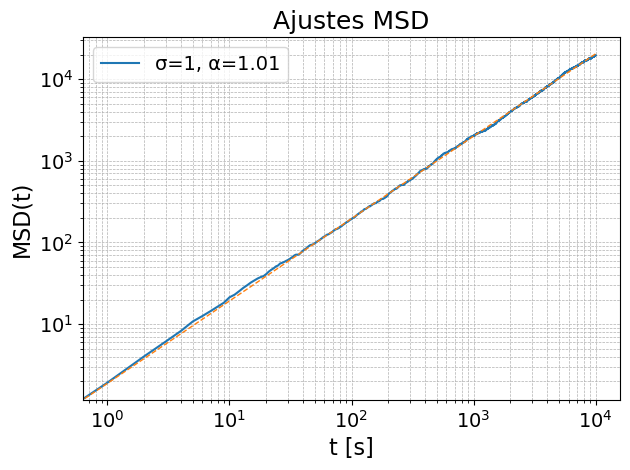

In [ ]:
plt.figure()
for sigma in sigmas:
    msd_stack = []
    for _ in range(N_sim):
        traj = brownian_2d(T_steps, sigma, dt_seconds)
        msd_stack.append(msd_from_initial_single(traj))
    msd_stack = np.stack(msd_stack, axis=0)
    msd_mean = msd_stack.mean(axis=0)
    # Ajustar exponente en el rango deseado
    alpha, b, r = fit_powerlaw_exponent(t, msd_mean, tmin=0, tmax=T_steps+1)
    # Graficar curva + recta ajustada
    plt.plot(t, msd_mean, label=f"σ={sigma}, α={alpha:.2f}")
    # Línea ajustada
    t_fit = t[(t>=0)&(t<=1000000)]
    plt.plot(t_fit, np.exp(b) * t_fit**alpha, "--", lw=1)

plt.xscale("log"); plt.yscale("log")
plt.xlabel("t [s]", fontsize=16)
plt.ylabel("MSD(t)", fontsize=16)
plt.title("Ajustes MSD", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)
plt.grid(True, which="both", ls="--", lw=0.5)
plt.tight_layout()
plt.show()


# Trayectorias Brownianas con pausas empíricas

In [7]:
DT = 1.7  # tamaño ventana
rng = np.random.default_rng()

# Rachas y samplers empíricos
def run_lengths(binary_array, value=0):
    x = (binary_array == value).astype(int)
    if len(x) == 0:
        return np.array([], dtype=int)
    diff = np.diff(np.r_[0, x, 0])
    starts = np.where(diff == 1)[0]
    ends   = np.where(diff == -1)[0]
    return (ends - starts).astype(int)


def make_bootstrap_sampler(lengths, min_len=1):
    lengths = np.asarray(lengths, dtype=int)
    lengths = lengths[lengths >= min_len]
    if len(lengths) == 0:
        return lambda n=1: np.ones(n, dtype=int)
    def sampler(n=1):
        idx = rng.integers(0, len(lengths), size=n)
        return lengths[idx]
    return sampler

# Generación de secuencia on/off 
def synthesize_onoff_sequence(n_steps, quiet_sampler, active_sampler, start_state=1):
    seq = []
    state = start_state
    while len(seq) < n_steps:
        L = int(quiet_sampler(1)[0] if state == 0 else active_sampler(1)[0])
        L = max(L, 1)
        L = min(L, n_steps - len(seq))
        seq.extend([state]*L)
        state = 1 - state
    return np.array(seq, dtype=int)


# Simuladores

def brownian_free_with_pauses(n_steps, sigma_active, sigma_quiet=0.0, actividades=None, start=(0.0,0.0), jitter_quiet=False):
    start = np.asarray(start, float)
    traj = np.zeros((n_steps+1, 2), float)
    traj[0] = start
    if actividades is None:
        actividades = np.ones(n_steps, dtype=int)

    for t in range(n_steps): 
        if actividades[t] == 1:
            step = rng.normal(0, sigma_active, size=2)
        else:
            if jitter_quiet and sigma_quiet > 0:
                step = rng.normal(0, sigma_quiet, size=2)
            else:
                step = np.array([0.0, 0.0])
        traj[t+1] = traj[t] + step
    return traj


# Pipeline completo

def build_empirical_samplers(csv_file, col_pred="pred_rf", quiet_label=0, max_quiet_len=None):
    df = pd.read_csv(csv_file)

    seq = (df[col_pred].values != quiet_label).astype(int)

    quiet_runs  = run_lengths(seq, value=0)
    active_runs = run_lengths(seq, value=1)

    # Filtrar rachas largas de quietud
    if max_quiet_len is not None:
        quiet_runs = [q for q in quiet_runs if q <= max_quiet_len]

    qsam = make_bootstrap_sampler(quiet_runs, min_len=1)
    asam = make_bootstrap_sampler(active_runs, min_len=1)
    return qsam, asam, seq

def fit_powerlaw_exponent(t, msd, tmin=None, tmax=None):
    mask = np.ones_like(t, dtype=bool)
    if tmin is not None:
        mask &= (t >= tmin)
    if tmax is not None:
        mask &= (t <= tmax)
    mask &= (t > 0) & (msd > 0)
    logt = np.log(t[mask])
    logmsd = np.log(msd[mask])
    slope, intercept, r, p, se = linregress(logt, logmsd)
    return slope, intercept, r

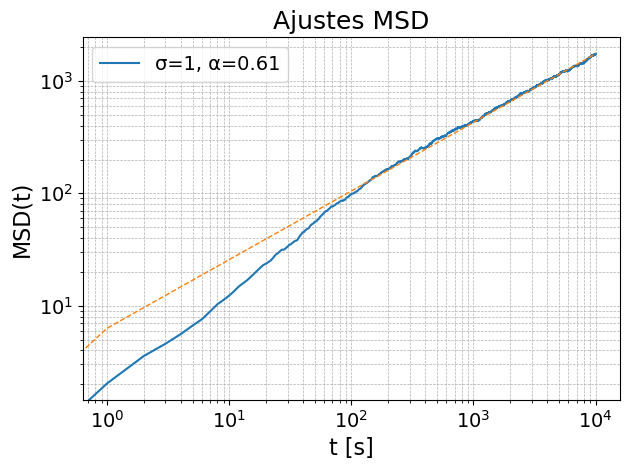

In [34]:
plt.figure()
qsam, asam, _ = build_empirical_samplers("pred_T337.csv", col_pred="pred_rf", quiet_label=0, max_quiet_len=max_quiet_len)
for sigma in sigmas:
    msd_stack = []
    for _ in range(N_sim):
        actividades = synthesize_onoff_sequence(T_steps, quiet_sampler=qsam, active_sampler=asam, start_state=1)
        traj = brownian_free_with_pauses(T_steps, sigma_active=sigma, sigma_quiet=0.0, actividades=actividades, start=(0.0,0.0), jitter_quiet=False)
        msd_stack.append(msd_from_initial_single(traj))
    msd_stack = np.stack(msd_stack, axis=0)
    msd_mean = msd_stack.mean(axis=0)
    # Ajustar exponente en el rango deseado
    alpha, b, r = fit_powerlaw_exponent(t, msd_mean, tmin=0, tmax=T_steps+1)
    # Graficar curva + recta ajustada
    plt.plot(t, msd_mean, label=f"σ={sigma}, α={alpha:.2f}")
    # Línea ajustada
    t_fit = t[(t>=0)&(t<=len(t))]
    plt.plot(t_fit, np.exp(b) * t_fit**alpha, "--", lw=1)

plt.xscale("log"); plt.yscale("log")
plt.xlabel("t [s]", fontsize=16)
plt.ylabel("MSD(t)", fontsize=16)
plt.title("Ajustes MSD", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)
plt.grid(True, which="both", ls="--", lw=0.5)
plt.tight_layout()
plt.show()



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


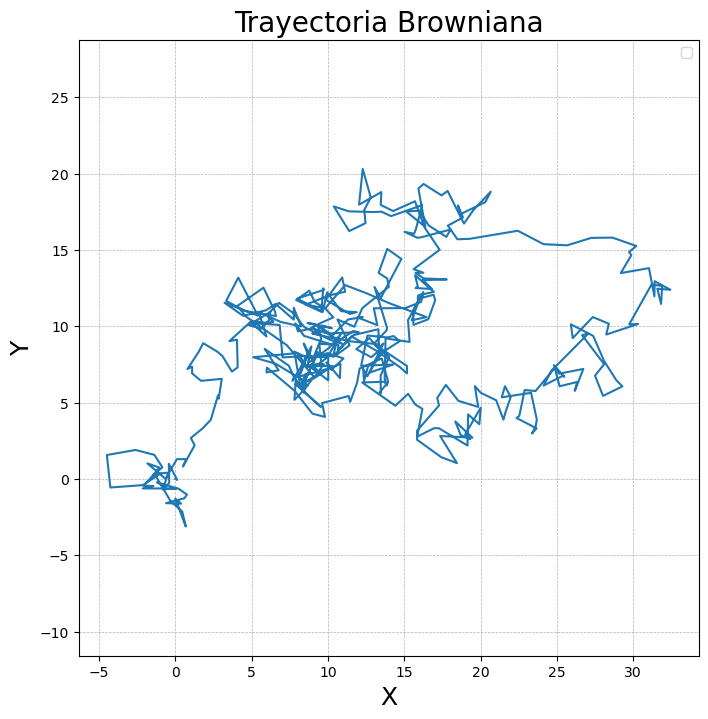

In [35]:
plt.figure(figsize=(8, 8))
plt.plot(traj[:, 0], traj[:, 1])
plt.xlabel("X", fontsize=18)
plt.ylabel("Y", fontsize=18)
plt.title("Trayectoria Browniana", fontsize=20)
plt.legend()
plt.grid(True, which="both", ls="--", lw=0.5)
plt.axis("equal")
plt.show()

# Trayectorias Brownianas con distribución de tamaño de paso powerlaw

In [8]:
import numpy as np

def sample_powerlaw_radii(n, r_min, r_max, alpha=2.0, rng=np.random.default_rng()):
    if not (r_min > 0 and r_max > r_min):
        raise ValueError("Se requiere 0 < r_min < r_max.")
    u = rng.random(n)

    if alpha == 1.0:
        return r_min * (r_max / r_min) ** u
    else:
        one_minus_alpha = 1.0 - alpha
        a = r_min**one_minus_alpha
        b = r_max**one_minus_alpha
        return (u * (b - a) + a) ** (1.0 / one_minus_alpha)
    
def make_gaussian_step_sampler(n, r0, sigma, rng=None):
    if rng is None:
        rng = np.random.default_rng()
    
    def sampler(n=1):
        # generar n valores con distribución normal
        steps = rng.normal(loc=r0, scale=sigma, size=int(n))
        # si los pasos son magnitudes, asegurar que sean positivos
        steps = np.abs(steps)
        return steps
    
    return sampler(n)

def make_uniform_step_sampler(n_steps, r_max, rng=None):
    if rng is None:
        rng = np.random.default_rng()
    
    def sampler(n=1):
        steps = rng.uniform(low=0.0, high=r_max, size=int(n))
        return steps
    
    return sampler(n_steps)

def brownian_uniform_steps(n_steps, r_max, start=(0.0, 0.0), rng=np.random.default_rng(), return_steps=False):
    start = np.asarray(start, float)
    r = make_uniform_step_sampler(n_steps, r_max)
    theta = rng.uniform(0.0, 2.0*np.pi, size=n_steps)
    steps = np.column_stack((r*np.cos(theta), r*np.sin(theta)))
    traj = np.zeros((n_steps+1, 2), dtype=float)
    traj[0] = start
    traj[1:] = start + np.cumsum(steps, axis=0)

    if return_steps:
        return traj, steps, r
    return traj

def brownian_gaussian_steps(n_steps, r0 , sigma, start=(0.0, 0.0), rng=np.random.default_rng(), return_steps=False):
    start = np.asarray(start, float)
    r = make_gaussian_step_sampler(n_steps, r0, sigma)
    theta = rng.uniform(0.0, 2.0*np.pi, size=n_steps)
    steps = np.column_stack((r*np.cos(theta), r*np.sin(theta)))
    traj = np.zeros((n_steps+1, 2), dtype=float)
    traj[0] = start
    traj[1:] = start + np.cumsum(steps, axis=0)

    if return_steps:
        return traj, steps, r
    return traj

def brownian_powerlaw_steps(n_steps, r_min, r_max, alpha=10, start=(0.0, 0.0), rng=np.random.default_rng(), return_steps=False):
    start = np.asarray(start, float)
    r = sample_powerlaw_radii(n_steps, r_min, r_max, alpha=alpha, rng=rng)
    theta = rng.uniform(0.0, 2.0*np.pi, size=n_steps)
    steps = np.column_stack((r*np.cos(theta), r*np.sin(theta)))
    traj = np.zeros((n_steps+1, 2), dtype=float)
    traj[0] = start
    traj[1:] = start + np.cumsum(steps, axis=0)

    if return_steps:
        return traj, steps, r
    return traj

def fit_powerlaw_exponent(t, msd, tmin=None, tmax=None):
    mask = np.ones_like(t, dtype=bool)
    if tmin is not None:
        mask &= (t >= tmin)
    if tmax is not None:
        mask &= (t <= tmax)
    mask &= (t > 0) & (msd > 0)
    logt = np.log(t[mask])
    logmsd = np.log(msd[mask])
    slope, intercept, r, p, se = linregress(logt, logmsd)
    return slope, intercept, r


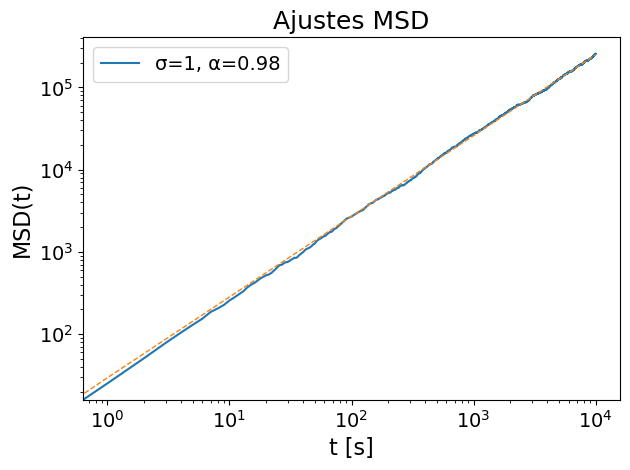

In [37]:
plt.figure()
for sigma in sigmas:
    msd_stack = []
    for _ in range(N_sim):
        #traj = brownian_powerlaw_steps(T_steps, r_min=0.1, r_max=1, alpha = 8.0, start = (0.0,0.0), rng=rng)
        traj=brownian_gaussian_steps(T_steps, r0=5 , sigma=1, start=(0.0, 0.0), rng=np.random.default_rng(), return_steps=False)
        #traj=brownian_uniform_steps(T_steps, r_max=50 , start=(0.0, 0.0), rng=np.random.default_rng(), return_steps=False)
        msd_stack.append(msd_from_initial_single(traj))
    msd_stack = np.stack(msd_stack, axis=0)
    msd_mean = msd_stack.mean(axis=0)
    # Ajustar exponente en el rango deseado
    alpha, b, r = fit_powerlaw_exponent(t, msd_mean, tmin=0, tmax=T_steps+1)
    # Graficar curva + recta ajustada
    plt.plot(t, msd_mean, label=f"σ={sigma}, α={alpha:.2f}")
    # Línea ajustada
    t_fit = t[(t>=0)&(t<=len(t))]
    plt.plot(t_fit, np.exp(b) * t_fit**alpha, "--", lw=1)

plt.xscale("log"); plt.yscale("log")
plt.xlabel("t [s]", fontsize=16)
plt.ylabel("MSD(t)", fontsize=16)
plt.title("Ajustes MSD", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)
plt.tight_layout()
plt.show()



# Trayectorias con distribución de pausas y tamaño de pasos

In [9]:
DT = 1.7  # tamaño ventana
rng = np.random.default_rng()

# Rachas y samplers empíricos

def run_lengths(binary_array, value=0):
    x = (binary_array == value).astype(int)
    if len(x) == 0:
        return np.array([], dtype=int)
    diff = np.diff(np.r_[0, x, 0])
    starts = np.where(diff == 1)[0]
    ends   = np.where(diff == -1)[0]
    return (ends - starts).astype(int)


def make_bootstrap_sampler(lengths, min_len=1):
    lengths = np.asarray(lengths, dtype=int)
    lengths = lengths[lengths >= min_len]
    if len(lengths) == 0:
        return lambda n=1: np.ones(n, dtype=int)
    def sampler(n=1):
        idx = rng.integers(0, len(lengths), size=n)
        return lengths[idx]
    return sampler

# Generación de secuencia on/off 

def synthesize_onoff_sequence(n_steps, quiet_sampler, active_sampler, start_state=1):
    seq = []
    state = start_state
    while len(seq) < n_steps:
        L = int(quiet_sampler(1)[0] if state == 0 else active_sampler(1)[0])
        L = max(L, 1)
        L = min(L, n_steps - len(seq))
        seq.extend([state]*L)
        state = 1 - state
    return np.array(seq, dtype=int)


# Simuladores

def brownian_free_with_pauses_powerlaw_steps(n_steps, sigma_active, sigma_quiet=0.0, actividades=None, start=(0.0,0.0), jitter_quiet=False, r_min=0.1, r_max=10, alpha=2.0):
    start = np.asarray(start, float)
    traj = np.zeros((n_steps+1, 2), float)
    traj[0] = start
    # r = sample_powerlaw_radii(n_steps, r_min, r_max, alpha=alpha, rng=rng)
    # r = make_gaussian_step_sampler(n_steps, r_max, sigma_active)
    r = make_uniform_step_sampler(n_steps, r_max)
    theta = rng.uniform(0.0, 2.0*np.pi, size=n_steps)
    steps = np.column_stack((r*np.cos(theta), r*np.sin(theta)))
    if actividades is None:
        actividades = np.ones(n_steps, dtype=int)

    for t in range(n_steps): 
        if actividades[t] == 1:
            step = steps[t]
        else:
            if jitter_quiet and sigma_quiet > 0:
                step = steps[t]
            else:
                step = np.array([0.0, 0.0])
        traj[t+1] = traj[t] + step
    return traj


# Pipeline completo

def build_empirical_samplers(csv_file, col_pred="pred_rf", quiet_label=0, max_quiet_len=None):
    df = pd.read_csv(csv_file)

    seq = (df[col_pred].values != quiet_label).astype(int)

    quiet_runs  = run_lengths(seq, value=0)
    active_runs = run_lengths(seq, value=1)

    # Filtrar rachas largas de quietud
    if max_quiet_len is not None:
        quiet_runs = [q for q in quiet_runs if q <= max_quiet_len]

    qsam = make_bootstrap_sampler(quiet_runs, min_len=1)
    asam = make_bootstrap_sampler(active_runs, min_len=1)
    return qsam, asam, seq


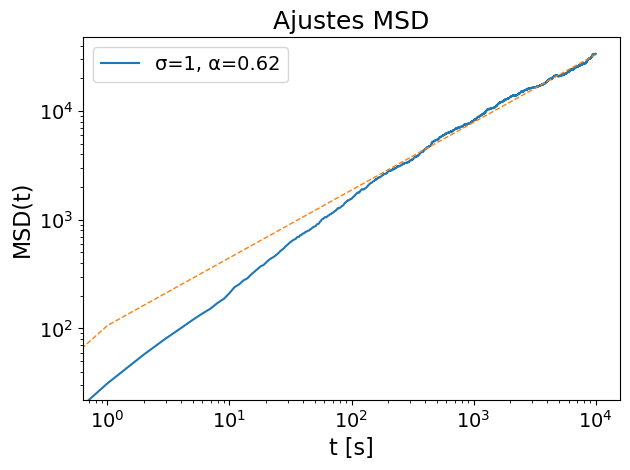

In [39]:
qsam, asam, _ = build_empirical_samplers("pred_T337.csv", col_pred="pred_rf", quiet_label=0, max_quiet_len=max_quiet_len)
plt.figure()
for sigma in sigmas:
    msd_stack = []
    for _ in range(N_sim):
        actividades = synthesize_onoff_sequence(T_steps, quiet_sampler=qsam, active_sampler=asam, start_state=1)
        traj = brownian_free_with_pauses_powerlaw_steps(T_steps, sigma_active=sigma, sigma_quiet=0.0, actividades=actividades, start=(0.0,0.0), jitter_quiet=False, r_min=0.1, r_max=10, alpha =2.0)
        msd_stack.append(msd_from_initial_single(traj))
    msd_stack = np.stack(msd_stack, axis=0)
    msd_mean = msd_stack.mean(axis=0)
    # Ajustar exponente en el rango deseado
    alpha, b, r = fit_powerlaw_exponent(t, msd_mean, tmin=0, tmax=T_steps+1)
    # Graficar curva + recta ajustada
    plt.plot(t, msd_mean, label=f"σ={sigma}, α={alpha:.2f}")
    # Línea ajustada
    t_fit = t[(t>=0)&(t<=len(t))]
    plt.plot(t_fit, np.exp(b) * t_fit**alpha, "--", lw=1)

plt.xscale("log"); plt.yscale("log")
plt.xlabel("t [s]", fontsize=16)
plt.ylabel("MSD(t)", fontsize=16)
plt.title("Ajustes MSD", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)
plt.tight_layout()
plt.show()




# Trayectorias con distribución de lapsos de quietud sintéticos

In [25]:
def make_powerlaw_sampler(alpha, Lmin=1, Lmax=None, rng=rng, method="continuous"):
    if alpha <= 1:
        raise ValueError("Se requiere alpha > 1 para tener media finita y sampler estable.")

    if method not in ("continuous", "zipf"):
        raise ValueError("method debe ser 'continuous' o 'zipf'.")

    if method == "continuous":
        def _sample_cont(n=1):
            n = int(n)
            out = np.empty(n, dtype=int)
            filled = 0
            while filled < n:
                m = n - filled
                U = rng.random(m)
                X = Lmin * (1.0 - U) ** (-1.0 / (alpha - 1.0))
                L = np.floor(X).astype(int) 
                if Lmax is not None:
                    keep = L <= Lmax
                    k = keep.sum()
                    if k > 0:
                        out[filled:filled+k] = L[keep]
                        filled += k
                else:
                    out[filled:filled+m] = L
                    filled += m
            return out
        return _sample_cont

    else:  # metodo == "zipf"
        def _sample_zipf(n=1):
            n = int(n)
            out = np.empty(n, dtype=int)
            filled = 0
            while filled < n:
                m = n - filled
                Z = rng.zipf(alpha, size=m)
                L = Z + (Lmin - 1) 
                if Lmax is not None:
                    keep = L <= Lmax
                    k = keep.sum()
                    if k > 0:
                        out[filled:filled+k] = L[keep]
                        filled += k
                else:
                    out[filled:filled+m] = L
                    filled += m
            return out
        return _sample_zipf


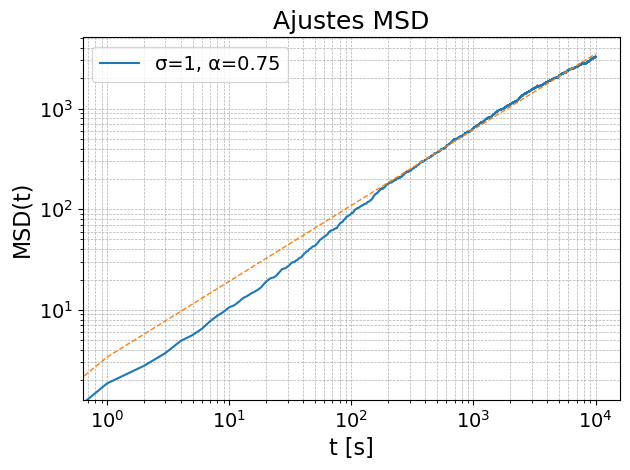

In [44]:
alpha_quiet  = 1.7  # exponente para rachas de quietud
alpha_active = 1.87  # exponente para rachas de actividad
Lmin_quiet   = 1
Lmin_active  = 1
Lmax_quiet   = 58823
Lmax_active  = 588

qsam = make_powerlaw_sampler(alpha_quiet,  Lmin=Lmin_quiet,  Lmax=Lmax_quiet,  rng=rng, method="zipf")
asam = make_powerlaw_sampler(alpha_active, Lmin=Lmin_active, Lmax=Lmax_active, rng=rng, method="zipf")

for sigma in sigmas:
    msd_stack = []
    for _ in range(N_sim):
        actividades = synthesize_onoff_sequence(T_steps, quiet_sampler=qsam, active_sampler=asam, start_state=1)
        traj = brownian_free_with_pauses(T_steps, sigma_active=sigma, sigma_quiet=0.0, actividades=actividades, start=(0.0,0.0), jitter_quiet=False)
        msd_stack.append(msd_from_initial_single(traj))
    msd_stack = np.stack(msd_stack, axis=0)
    msd_mean = msd_stack.mean(axis=0)
    # Ajustar exponente en el rango deseado
    alpha, b, r = fit_powerlaw_exponent(t, msd_mean, tmin=0, tmax=T_steps+1)
    # Graficar curva + recta ajustada
    plt.plot(t, msd_mean, label=f"σ={sigma}, α={alpha:.2f}")
    # Línea ajustada
    t_fit = t[(t>=0)&(t<=len(t))]
    plt.plot(t_fit, np.exp(b) * t_fit**alpha, "--", lw=1)

plt.xscale("log"); plt.yscale("log")
plt.xlabel("t [s]", fontsize=16)
plt.ylabel("MSD(t)", fontsize=16)
plt.title("Ajustes MSD", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)
plt.grid(True, which="both", ls="--", lw=0.5)
plt.tight_layout()
plt.show()



# Distribucion de tamaño de pasos powelaw y tiempos de quietud powerlaw

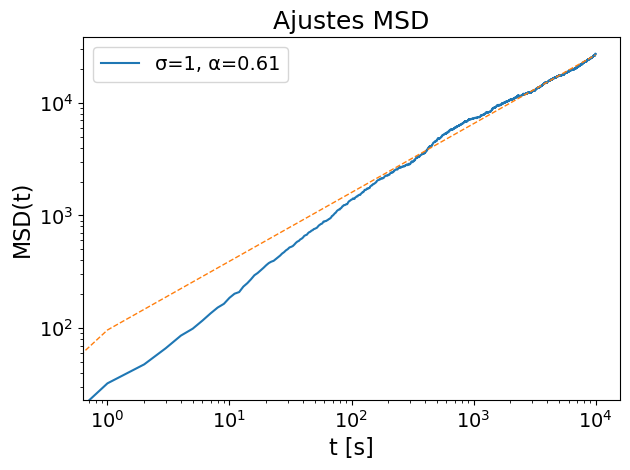

In [46]:
alpha_quiet  = 1.44  # exponente para rachas de quietud
alpha_active = 1.59  # exponente para rachas de actividad
Lmin_quiet   = 1
Lmin_active  = 1
Lmax_quiet   = 58823
Lmax_active  = 588

qsam = make_powerlaw_sampler(alpha_quiet,  Lmin=Lmin_quiet,  Lmax=Lmax_quiet,  rng=rng, method="zipf")
asam = make_powerlaw_sampler(alpha_active, Lmin=Lmin_active, Lmax=Lmax_active, rng=rng, method="zipf")
plt.figure()
for sigma in sigmas:
    msd_stack = []
    for _ in range(N_sim):
        actividades = synthesize_onoff_sequence(T_steps, quiet_sampler=qsam, active_sampler=asam, start_state=1)
        traj = brownian_free_with_pauses_powerlaw_steps(T_steps, sigma_active=sigma, sigma_quiet=0.0, actividades=actividades, start=(0.0,0.0), jitter_quiet=False, r_min=0.1, r_max=10, alpha =2.0)
        msd_stack.append(msd_from_initial_single(traj))
    msd_stack = np.stack(msd_stack, axis=0)
    msd_mean = msd_stack.mean(axis=0)

    # Eje temporal consistente con msd_mean:
    dt_eff = 1.0  # usa tu Δt real (p. ej., 900.0 si cada “paso” es 15 min)
    t_axis = np.arange(msd_mean.size, dtype=float) * dt_eff

    alpha_fit, b, r = fit_powerlaw_exponent(t_axis, msd_mean, tmin=t_axis[1], tmax=t_axis[-1])

    plt.plot(t_axis, msd_mean, label=f"σ={sigma}, α={alpha_fit:.2f}")
    t_fit = t_axis
    plt.plot(t_fit, np.exp(b) * t_fit**alpha_fit, "--", lw=1)

plt.xscale("log"); plt.yscale("log")
plt.xlabel("t [s]", fontsize=16)
plt.ylabel("MSD(t)", fontsize=16)
plt.title("Ajustes MSD", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)
plt.tight_layout()
plt.show()




In [45]:
import numpy as np
import matplotlib.pyplot as plt

def step_lengths_by_lag(traj, lags_steps):
    """
    Calcula |r(t+lag) - r(t)| para cada lag (en pasos).
    traj: array (T+1, 2) o (T+1, d)
    lags_steps: lista de enteros positivos
    return: dict {lag: array de longitudes}
    """
    traj = np.asarray(traj)
    assert traj.ndim == 2, "traj debe ser (T+1, d)"
    out = {}
    for k in sorted(set(int(l) for l in lags_steps if int(l) > 0)):
        dif = traj[k:] - traj[:-k]               # (T+1-k, d)
        lengths = np.linalg.norm(dif, axis=1)    # (T+1-k,)
        out[k] = lengths
    return out

def lags_seconds_to_steps(lags_seconds, dt_seconds):
    """
    Convierte lags en segundos a pasos discretos, redondeando al entero más cercano
    y asegurando al menos 1 paso.
    """
    return [max(1, int(round(L / dt_seconds))) for L in lags_seconds]

def common_log_bins(lengths_dict, nbins=40, eps=1e-12):
    """
    Construye bins logarítmicos comunes a partir de todas las longitudes.
    Evita ceros con eps.
    """
    all_vals = np.concatenate([v for v in lengths_dict.values() if len(v) > 0])
    all_vals = all_vals[all_vals > 0]
    if len(all_vals) == 0:
        raise ValueError("Todas las longitudes son cero; no se pueden crear bins.")
    vmin = all_vals.min()
    vmax = all_vals.max()
    vmin = max(vmin, eps)
    edges = np.logspace(np.log10(vmin), np.log10(vmax), nbins+1)
    return edges

def hist_pdfs_by_lag(lengths_dict, bins):
    """
    Calcula PDFs normalizadas por lag con bins comunes.
    return: dict {lag: (centros, pdf)}
    """
    pdfs = {}
    centers = 0.5 * (bins[1:] + bins[:-1])
    widths  = np.diff(bins)
    for lag, vals in lengths_dict.items():
        hist, _ = np.histogram(vals, bins=bins, density=False)
        # Normalización a PDF: suma(hist * width) = 1
        pdf = hist / (hist.sum() * widths + 1e-12)
        pdfs[lag] = (centers, pdf)
    return pdfs

def summarize_lengths(lengths_dict):
    """
    Devuelve estadísticas básicas por lag.
    """
    summary = {}
    for lag, vals in lengths_dict.items():
        if len(vals) == 0:
            summary[lag] = {"n": 0, "mean": np.nan, "std": np.nan, "p50": np.nan, "p90": np.nan}
        else:
            summary[lag] = {
                "n":   int(len(vals)),
                "mean": float(np.mean(vals)),
                "std":  float(np.std(vals, ddof=1)),
                "p50":  float(np.percentile(vals, 50)),
                "p90":  float(np.percentile(vals, 90)),
            }
    return summary







In [50]:
def make_normal_sampler(mu, sigma, nonneg=True, rng=None):
    rng = np.random.default_rng() if rng is None else rng
    def _sample(n=1):
        r = rng.normal(mu, sigma, size=n)
        if nonneg:
            r = np.clip(r, 0.0, None)
        return r
    return _sample  # <-- devolvemos la FUNCIÓN, no los datos

def make_uniform_sampler(r_min, r_max, rng=None):
    rng = np.random.default_rng() if rng is None else rng
    def _sample(n=1):
        return rng.uniform(r_min, r_max, size=n)
    return _sample  # <-- función

def make_powerlaw_sampler(alpha, Lmin=1.0, Lmax=None, rng=None):
    if alpha == 1:
        raise ValueError("Para alpha=1 se requiere un tratamiento especial (log-uniforme). Usa alpha != 1.")
    rng = np.random.default_rng() if rng is None else rng

    def _sample(n=1):
        u = rng.random(n)
        if Lmax is None:
            # Cola pura
            u = np.clip(u, 1e-12, 1-1e-12)
            return Lmin * (1 - u)**(-1.0/(alpha - 1.0))
        else:
            if Lmax <= Lmin:
                raise ValueError("Se requiere Lmax > Lmin.")
            a = 1.0 - alpha
            c0 = Lmin**a
            c1 = Lmax**a
            return (u*(c1 - c0) + c0)**(1.0/a)
    return _sample  # <-- función


# =========================
# Random walk usando sampler
# =========================

def random_walk_with_lengths(
    n_steps,
    length_sampler,
    actividades=None,
    start=(0.0, 0.0),
    jitter_quiet=False,
    sigma_quiet=0.0,
    rng=None
):
    rng = np.random.default_rng() if rng is None else rng
    start = np.asarray(start, float)

    traj = np.zeros((n_steps+1, 2), float)
    traj[0] = start

    if actividades is None:
        actividades = np.ones(n_steps, dtype=int)
    else:
        actividades = np.asarray(actividades, dtype=int)
        if len(actividades) != n_steps:
            raise ValueError("actividades debe tener largo n_steps.")

    # Direcciones aleatorias y longitudes
    theta = rng.uniform(0.0, 2*np.pi, size=n_steps)
    lengths = length_sampler(n_steps)  # <- ahora sí funciona

    for t in range(n_steps):
        if actividades[t] == 1:
            r = float(lengths[t])
            step = np.array([r*np.cos(theta[t]), r*np.sin(theta[t])], dtype=float)
        else:
            if jitter_quiet and sigma_quiet > 0:
                step = rng.normal(0.0, sigma_quiet, size=2)
            else:
                step = np.array([0.0, 0.0], dtype=float)
        traj[t+1] = traj[t] + step

    return traj


# =========================
# Wrapper principal
# =========================

def brownian_with_distributed_steps(
    n_steps,
    dist="normal",
    dist_params=None,
    actividades=None,
    start=(0.0, 0.0),
    jitter_quiet=False,
    sigma_quiet=0.0,
    rng=None
):
    rng = np.random.default_rng() if rng is None else rng
    dist_params = {} if dist_params is None else dict(dist_params)

    if dist == "normal":
        mu = dist_params.get("mu", 0.0)
        sigma = dist_params.get("sigma", 1.0)
        nonneg = dist_params.get("nonneg", True)
        sampler = make_normal_sampler(mu, sigma, nonneg=nonneg, rng=rng)

    elif dist == "uniform":
        rmin = dist_params.get("r_min", 0.0)
        rmax = dist_params.get("r_max", 1.0)
        sampler = make_uniform_sampler(rmin, rmax, rng=rng)

    elif dist == "powerlaw":
        alpha = dist_params.get("alpha", 2.5)
        Lmin  = dist_params.get("Lmin", 1.0)
        Lmax  = dist_params.get("Lmax", None)
        sampler = make_powerlaw_sampler(alpha, Lmin=Lmin, Lmax=Lmax, rng=rng)

    else:
        raise ValueError("dist debe ser 'normal', 'uniform' o 'powerlaw'.")

    return random_walk_with_lengths(
        n_steps=n_steps,
        length_sampler=sampler,
        actividades=actividades,
        start=start,
        jitter_quiet=jitter_quiet,
        sigma_quiet=sigma_quiet,
        rng=rng
    )

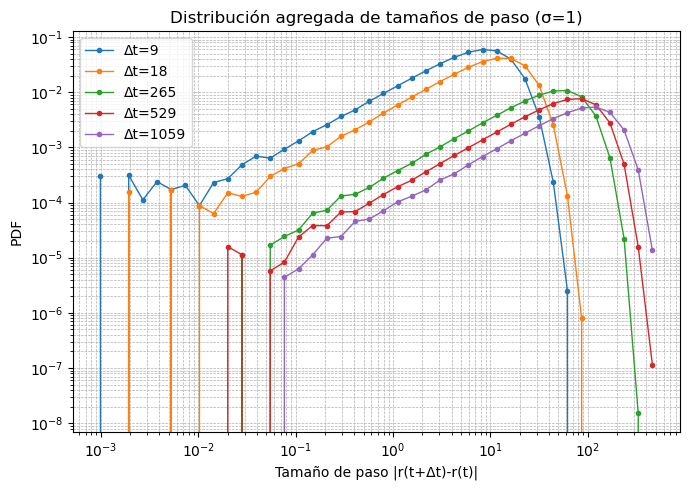

In [51]:
dt_seconds = 1.7
lags_steps = lags_seconds_to_steps([15, 30, 450,900,1800], dt_seconds)

lengths_all = {int(k): [] for k in lags_steps if int(k) > 0}

for sigma in sigmas:
    msd_stack = []
    # reiniciar acumuladores por sigma
    lengths_all_sigma = {k: [] for k in lengths_all.keys()}

    for _ in range(N_sim):
        actividades = synthesize_onoff_sequence(T_steps, quiet_sampler=qsam, active_sampler=asam, start_state=1)
        traj = brownian_with_distributed_steps(T_steps, dist="normal", dist_params=dict(mu=2, sigma=5, nonneg=True), actividades=None, jitter_quiet=False)
        # traj = brownian_with_distributed_steps(T_steps, dist="uniform", dist_params=dict(r_min=0, r_max=15), actividades=actividades,jitter_quiet=False)
        # traj = brownian_with_distributed_steps(T_steps, dist="powerlaw", dist_params=dict(alpha=2, Lmin=0.001, Lmax=10), actividades=actividades, jitter_quiet=False)
        # msd_stack.append(msd_from_initial_single(traj))

        lengths_dict = step_lengths_by_lag(traj, lags_steps)
        for k, v in lengths_dict.items():
            lengths_all_sigma[k].append(v)

    lengths_all_sigma = {k: np.concatenate(v) if len(v)>0 else np.array([])
                         for k, v in lengths_all_sigma.items()}


    bins = common_log_bins(lengths_all_sigma, nbins=40)
    pdfs = hist_pdfs_by_lag(lengths_all_sigma, bins)

    # summary = summarize_lengths(lengths_all_sigma)
    # print(f"\n== σ={sigma} ==")
    # for lag, s in summary.items():
    #     print(f"Δt={lag} pasos -> n={s['n']}, mean={s['mean']:.4g}, std={s['std']:.4g}, "
    #           f"p50={s['p50']:.4g}, p90={s['p90']:.4g}")


    centers = 0.5*(bins[1:]+bins[:-1])
    plt.figure(figsize=(7,5))
    for lag in sorted(pdfs.keys()):
        c, pdf = pdfs[lag]
        plt.plot(c, pdf, marker='o', ms=3, lw=1, label=f"Δt={lag}")
    plt.xscale("log"); plt.yscale("log")
    plt.xlabel("Tamaño de paso |r(t+Δt)-r(t)|")
    plt.ylabel("PDF")
    plt.title(f"Distribución agregada de tamaños de paso (σ={sigma})")
    plt.grid(True, which="both", ls="--", lw=0.5)
    plt.legend()
    plt.tight_layout()
    plt.show()
